In [1]:
import pandas as pd
import draft.data_cleaning as dc

In [2]:
person_0 = pd.read_json(r'datasets/december/liza.json', lines=True) # liza
person_1 = pd.read_json(r'datasets/december/sleep_data_Adham.json', lines=True) # adham
person_2 = pd.read_json(r'datasets/december/sleep_data_Miriam.json', lines=True) # miriam
person_3 = pd.read_json(r'datasets/december/sleep_data_Syahid.json', lines=True) # syahid
person_4 = pd.read_json(r'datasets/december/sleep_data_Florian.json', lines=True) # florian
person_5 = pd.read_json(r'datasets/december/sleep_data_Shado.json', lines=True) # shado
person_6 = pd.read_json(r'datasets/december/sleep_data_Alina.json', lines=True) # alina

# labels dataframe from excel
labels_df = pd.read_excel(r'datasets\sleep_data.xlsx', sheet_name=None) # dict of all label

In [3]:
people_df = [person_0, person_1, person_2, person_3, person_4, person_5, person_6]

for num, df in enumerate(people_df):
    df.insert(0, "temp_id", num)

In [4]:
def get_static_data(df):
    # Extract temp_id
    temp_id = df['temp_id']

    # static data from dailySleepDTO json
    sleepDTO_df = pd.json_normalize(df['dailySleepDTO'])

    cols_to_keep = ['id', 'calendarDate', 'sleepTimeSeconds', 'sleepStartTimestampLocal',
       'sleepEndTimestampLocal', 'deepSleepSeconds', 'lightSleepSeconds',
       'remSleepSeconds', 'awakeSleepSeconds', 'averageRespirationValue',
       'lowestRespirationValue', 'highestRespirationValue', 'awakeCount',
       'avgSleepStress', 'ageGroup', 'sleepVersion',
       'sleepScores.totalDuration.qualifierKey',
       'sleepScores.stress.qualifierKey',
       'sleepScores.awakeCount.qualifierKey', 'sleepScores.overall.value',
       'sleepScores.remPercentage.value',
       'sleepScores.remPercentage.idealStartInSeconds',
       'sleepScores.remPercentage.idealEndInSeconds',
       'sleepScores.restlessness.qualifierKey',
       'sleepScores.lightPercentage.value',
       'sleepScores.lightPercentage.idealStartInSeconds',
       'sleepScores.lightPercentage.idealEndInSeconds',
       'sleepScores.deepPercentage.value',
       'sleepScores.deepPercentage.idealStartInSeconds',
       'sleepScores.deepPercentage.idealEndInSeconds']
    
    sleepDTO_df = sleepDTO_df[cols_to_keep]

    # Add temp_id to the sleepDTO_df
    sleepDTO_df['temp_id'] = temp_id 

    # change the time format
    sleepDTO_df['sleepStartTimestampLocal'] = pd.to_datetime(sleepDTO_df['sleepStartTimestampLocal'], unit='ms')
    sleepDTO_df['sleepEndTimestampLocal'] = pd.to_datetime(sleepDTO_df['sleepEndTimestampLocal'], unit='ms')

    return sleepDTO_df

In [5]:
def combine_static_data(df):
    # Process the sleepDTO data
    sleepDTO = get_static_data(df)

    # Extract the required static values from the original DataFrame
    cols = ['temp_id', 'remSleepData', 'restlessMomentsCount', 'avgOvernightHrv', 'restingHeartRate']
    static_values = df[cols]

    # Set 'temp_id' as the index for both DataFrames
    static_values.set_index('temp_id', inplace=True)
    sleepDTO.set_index('temp_id', inplace=True)

    # Concatenate static_values and sleepDTO horizontally
    combined_data = pd.concat([sleepDTO, static_values], axis=1)

    # Reset the index if you want 'temp_id' back as a column
    combined_data.reset_index(inplace=True)

    return combined_data

In [6]:
def process_dataframe(dataframe):
    for col in dataframe.columns:
        if col.endswith("qualifierKey"):
            new_name = col.replace("qualifierKey", "value")
            dataframe[new_name] = dataframe[col].apply(dc.convert_num)
            dataframe.drop(col, axis=1, inplace=True)
    
    return dataframe

In [7]:
people_dict = {0: 'Liza', 1: 'Adham', 2: 'Miriam', 3: 'Syahid', 4: 'Florian', 5: 'Shado', 6: 'Alina'} # excel

persons_static_data = {
    0 : person_0,
    1 : person_1,
    2 : person_2,
    3 : person_3,
    4 : person_4,
    5 : person_5,
    6 : person_6
}

def process_all_people(persons_static_data): # we put persons_data as the argument
    processed_people = {}

    for person_id, person_df in persons_static_data.items():
        # Clean the data for each person
        cleaned_df = dc.delete_untracked_nights(person_df)

        # Combine the static data
        combined_df = combine_static_data(cleaned_df)

        # Process the DataFrame to change 'qualifierKey' to numerical value
        final_processed_df = process_dataframe(combined_df)

        # Load the embeddings DataFrame from a pickle file according to person id
        embeddings_file_name = f"datasets/embeddings_100/embeddings_{person_id}.pkl"
        embeddings_df = pd.read_pickle(embeddings_file_name)

        # combine the static and the embeddings
        combined_df_with_embeddings = pd.concat([final_processed_df, embeddings_df], axis=1)

        # Store the processed DataFrame in the dictionary with the same person_id
        processed_people[person_id] = combined_df_with_embeddings

    return processed_people

In [8]:
all_df = process_all_people(persons_static_data)

In [9]:
def merge_with_labels(persons_data, labels_df, people_dict):
    merged_data = {}

    for person_id, person_df in persons_data.items():
        # Check if 'calendarDate' exists in person_df
        if 'calendarDate' not in person_df.columns:
            print(f"'calendarDate' column not found in person data for {person_id}")
            continue

        # Get the label DataFrame for the current person
        person_label_df = labels_df[people_dict[person_id]]

        # Ensure the date columns are in the same format
        person_df['calendarDate'] = pd.to_datetime(person_df['calendarDate'])
        person_label_df['Datum'] = pd.to_datetime(person_label_df['Datum'])

        # Merge the person's data with their labels on the date
        merged_df = pd.merge(person_df, person_label_df, left_on='calendarDate', right_on='Datum')

        # Store the merged DataFrame in the dictionary with the same person_id
        merged_data[person_id] = merged_df

    return merged_data

# Example usage
merged_people_data = merge_with_labels(all_df, labels_df, people_dict)

In [10]:
data = pd.DataFrame()
# combine all data of all people
for df in merged_people_data.values():
    #print(df.shape)
    data = pd.concat([data, df])

data.drop('Datum', axis='columns', inplace=True)
data

,temp_id,id,calendarDate,sleepTimeSeconds,sleepStartTimestampLocal,sleepEndTimestampLocal,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,...,embedding_98,embedding_99,ausgeschlafen,motivation,konzentriert,Wach,Test_zeit,Test_anzahl,prozent_zeit_rang,prozent_anzahl
0,0,1701986940000,2023-12-08,36780,2023-12-07 23:09:00,2023-12-08 09:34:00,3780,27000,6000,720,...,0.131409,0.0,4,3,4,2,NaN,NaN,NaN,NaN
1,0,1702078860000,2023-12-09,29940,2023-12-09 00:41:00,2023-12-09 09:42:00,3240,24480,2220,2520,...,0.350698,0.0,5,5,4,4,80.33,71.0,32.0,6.0
2,0,1702171920000,2023-12-10,25080,2023-12-10 02:32:00,2023-12-10 09:39:00,2040,17580,5460,540,...,0.000000,0.0,4,2,3,2,79.33,27.0,33.0,7.0
3,0,1702254240000,2023-12-11,21420,2023-12-11 01:24:00,2023-12-11 07:22:00,3720,15000,2700,60,...,0.000000,0.0,4,4,5,3,100.00,87.0,61.0,28.0
4,0,1702340700000,2023-12-12,31080,2023-12-12 01:25:00,2023-12-12 10:04:00,6540,17520,7020,60,...,0.000000,0.0,5,5,4,2,85.00,81.0,32.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,6,1702856640000,2023-12-18,22620,2023-12-18 00:44:00,2023-12-18 07:11:00,2940,15720,3960,600,...,0.000000,0.0,3,3,3,3,51.00,97.0,0.0,81.0
6,6,1702940220000,2023-12-19,25800,2023-12-18 23:57:00,2023-12-19 07:10:00,2640,15420,7740,180,...,0.000000,0.0,3,3,4,3,47.70,93.0,0.0,62.0
7,6,1703028000000,2023-12-20,26520,2023-12-20 00:20:00,2023-12-20 07:59:00,3420,15120,7980,1020,...,0.000000,0.0,4,4,3,3,44.33,88.0,0.0,33.0
8,6,1703113800000,2023-12-21,28320,2023-12-21 00:10:00,2023-12-21 08:07:00,1200,19860,7260,300,...,0.000000,0.0,5,5,3,3,44.70,95.0,0.0,72.0


### data without high correlated values

In [11]:
cols_to_remove = ['awakeCount', 'lowestRespirationValue', 'highestRespirationValue',
                  'sleepScores.remPercentage.idealStartInSeconds', 'sleepScores.remPercentage.idealEndInSeconds', 'sleepScores.lightPercentage.idealStartInSeconds',
                  'sleepScores.lightPercentage.idealEndInSeconds', 'sleepScores.deepPercentage.idealStartInSeconds', 'sleepScores.deepPercentage.idealEndInSeconds',
                  'sleepScores.remPercentage.value', 'sleepScores.lightPercentage.value', 'sleepScores.deepPercentage.value', 
                  'sleepVersion', 'remSleepData',
                  'sleepScores.totalDuration.value', 'sleepScores.stress.value', 'sleepScores.awakeCount.value', 'sleepScores.restlessness.value']

data_filtered = data.drop(cols_to_remove, axis='columns')

### PCA & Outlier detection

Text(0, 0.5, 'cumulative explained variance')

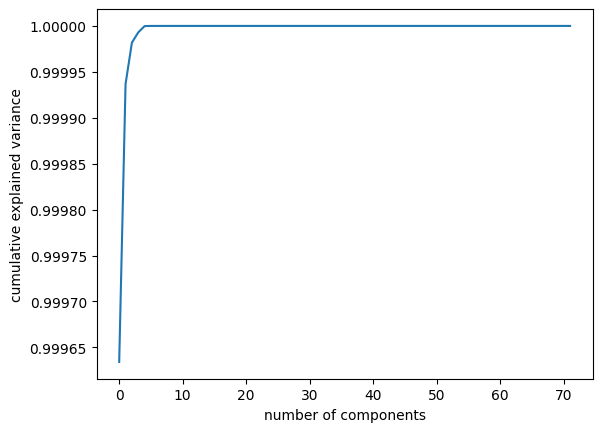

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

data_clean = data_filtered.dropna().reset_index()
copy_data_clean = data_clean.copy()

cols_to_drop = ['index', 'temp_id', 'id', 'calendarDate', 'ageGroup',
                'ausgeschlafen', 'motivation', 'Wach', 'konzentriert',
                'Test_zeit', 'Test_anzahl','prozent_zeit_rang', 'prozent_anzahl']
data_clean.drop(cols_to_drop, axis='columns', inplace=True)

# Convert Timestamp to Unix format
data_clean['sleepStartTimestampLocal'] = data_clean['sleepStartTimestampLocal'].astype('int64') // 10**9
data_clean['sleepEndTimestampLocal'] = data_clean['sleepEndTimestampLocal'].astype('int64') // 10**9

pca = PCA().fit(data_clean)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [13]:
# create a PCA object
pca = PCA(n_components=2)  # Reduce to 3 features
reduced_data_pca = pca.fit_transform(data_clean)

print(reduced_data_pca.shape)  # Should print (122, 3)

(72, 2)


In [32]:
from sklearn.ensemble import IsolationForest

# Create the model
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.1,
    n_jobs=-1,
    random_state=42,
    verbose=0)

# Fit the model
iso_forest.fit(reduced_data_pca)

# Predict degree of anomaly
scores_pred = iso_forest.decision_function(reduced_data_pca)

# Set the threshold
threshold = -0.01  # Adjust this value to suit your needs

# Classify data points as outliers if their anomaly score is less than the threshold
outlier_classification = np.where(scores_pred < threshold, -1, 1)

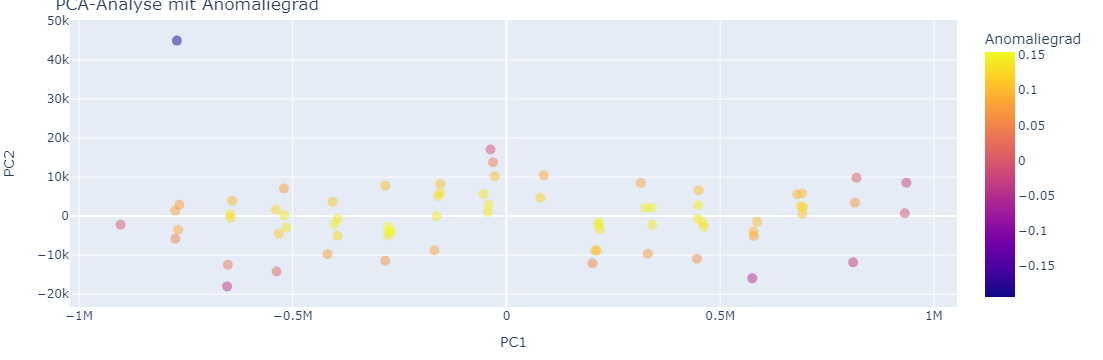

In [33]:
import plotly.express as px

df = pd.DataFrame(reduced_data_pca, columns=['PC1', 'PC2'])
df['AnomalyDegree'] = scores_pred  # Fügen Sie die Anomaliewerte als Spalte hinzu
# Erstellen Sie den Plot mit Plotly Express
fig = px.scatter(df, x='PC1', y='PC2', color='AnomalyDegree',
                 color_continuous_scale='Plasma',  # Verwenden Sie die Plasma-Farbpalette
                 title='PCA-Analyse mit Anomaliegrad',
                 labels={'AnomalyDegree': 'Anomaliegrad'})
 
# Verbesserungen für Interaktivität
fig.update_traces(marker=dict(size=10, opacity=0.5))  # Passen Sie die Markergröße und -transparenz an
fig.update_layout(coloraxis_colorbar=dict(title='Anomaliegrad'))  # Farblegende titeln
fig.update_layout(margin=dict(l=20, r=20, t=20, b=20))  # Randabstände anpassen
 
# Zeigen Sie den Plot an
fig.show()

In [34]:
# find out which samples are the outliers
outlier_indices = np.where(outlier_classification == -1)[0]
print("Outlier indices:", outlier_indices)
print("Number of outliers:", len(outlier_indices))

Outlier indices: [14 16 25 39 60]
Number of outliers: 5


In [38]:
copy_data_clean.iloc[outlier_indices, 4:]

,sleepTimeSeconds,sleepStartTimestampLocal,sleepEndTimestampLocal,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,averageRespirationValue,avgSleepStress,ageGroup,...,embedding_98,embedding_99,ausgeschlafen,motivation,konzentriert,Wach,Test_zeit,Test_anzahl,prozent_zeit_rang,prozent_anzahl
14,18180,2023-12-09 04:08:00,2023-12-09 09:20:00,6060,7140,4980,540,15.0,16.0,ADULT,...,0.000000,0.0,2,4,2,1,65.00,60.0,15.0,0.0
16,15000,2023-12-11 02:58:00,2023-12-11 07:11:00,4920,6660,3420,180,16.0,10.0,ADULT,...,1.262042,0.0,3,4,3,3,112.00,95.0,78.0,72.0
25,32700,2023-12-08 01:42:00,2023-12-08 10:48:00,5520,16440,10740,60,13.0,13.0,ADULT,...,0.000000,0.0,4,4,4,2,54.67,32.0,1.0,0.0
39,53700,2023-12-21 21:14:00,2023-12-22 13:47:00,3720,44460,5520,2400,19.0,0.0,ADULT,...,0.596457,0.0,2,2,3,3,64.67,100.0,4.0,90.0
60,13320,2023-12-21 04:29:00,2023-12-21 08:21:00,4500,8460,360,600,13.0,17.0,ADULT,...,1.113500,0.0,2,4,4,2,34.67,100.0,0.0,90.0


In [17]:
outlier_classifications = []
anomaly_degrees = []

for contamination in [0.01, 0.1, 0.2, 0.4]:

    # Create the model
    iso_forest = IsolationForest(
        n_estimators=100,
        contamination=contamination,
        n_jobs=-1,
        random_state=42)

    # Fit the model
    iso_forest.fit(reduced_data_pca)

    # Classify as outlier / no outlier
    outlier_classifications.append(iso_forest.predict(reduced_data_pca))
    anomaly_degrees.append(iso_forest.decision_function(reduced_data_pca))

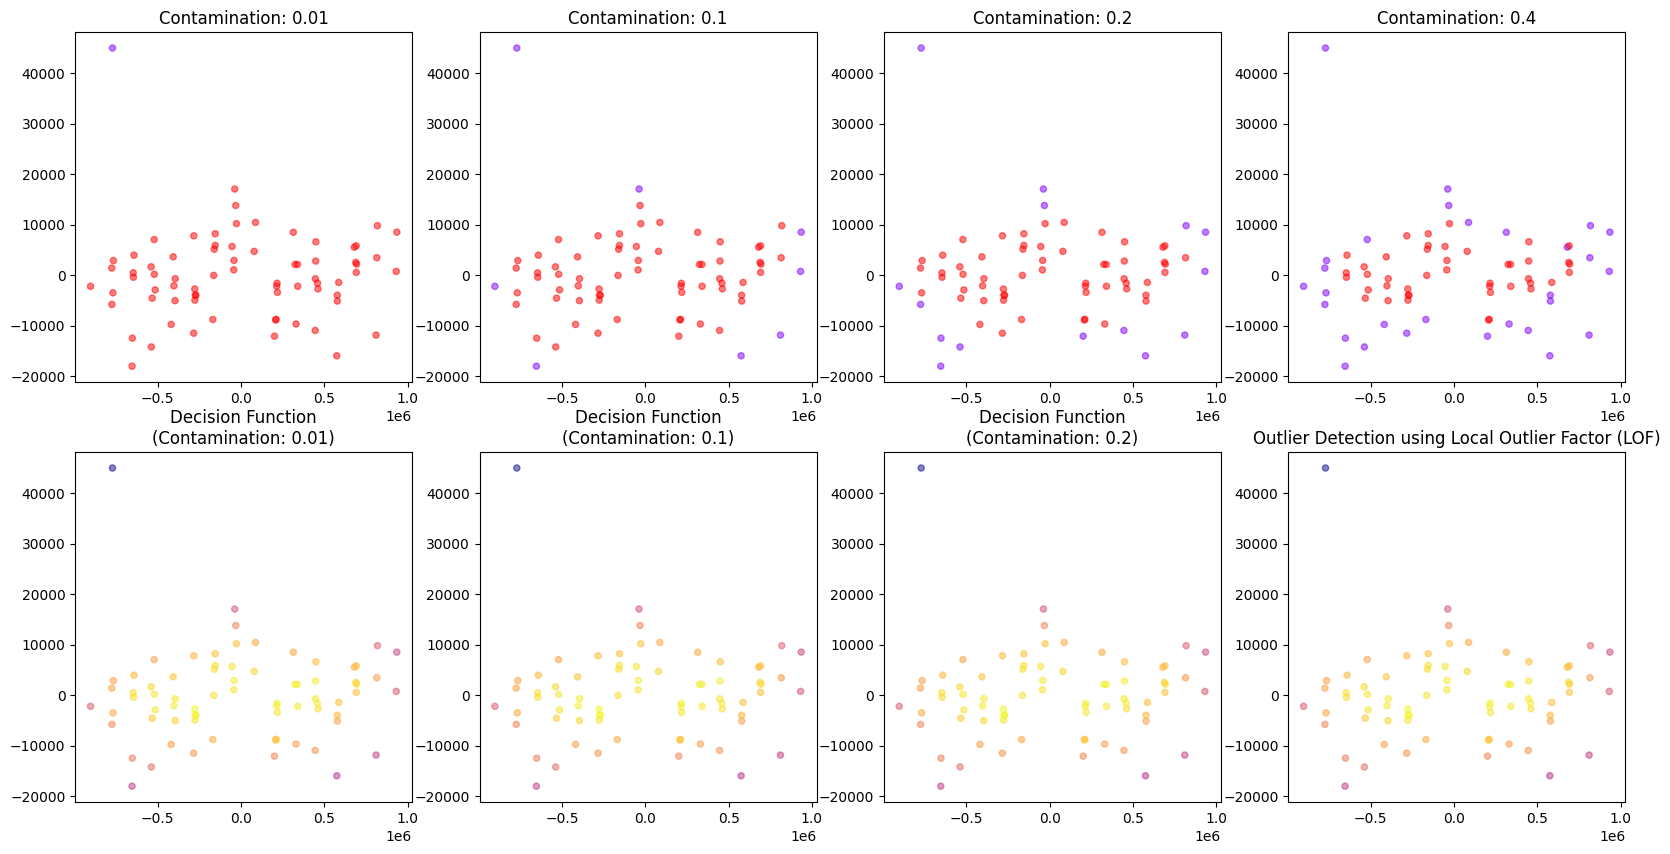

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, contamination in enumerate([0.01, 0.1, 0.2, 0.4]):
    axes[0, i].scatter(
        reduced_data_pca[:, 0], reduced_data_pca[:, 1],
        c=outlier_classifications[i], cmap="rainbow",
        alpha=0.5,
        s=20)
    axes[0, i].set_title(f"Contamination: {contamination}")

for i, contamination in enumerate([0.01, 0.1, 0.2, 0.4]):
    axes[1, i].scatter(
        reduced_data_pca[:, 0], reduced_data_pca[:, 1],
        c=anomaly_degrees[i], cmap="plasma",
        alpha=0.5,
        s=20)
    axes[1, i].set_title(f"Decision Function\n(Contamination: {contamination})")

plt.title("Outlier Detection using Local Outlier Factor (LOF)")
plt.show()

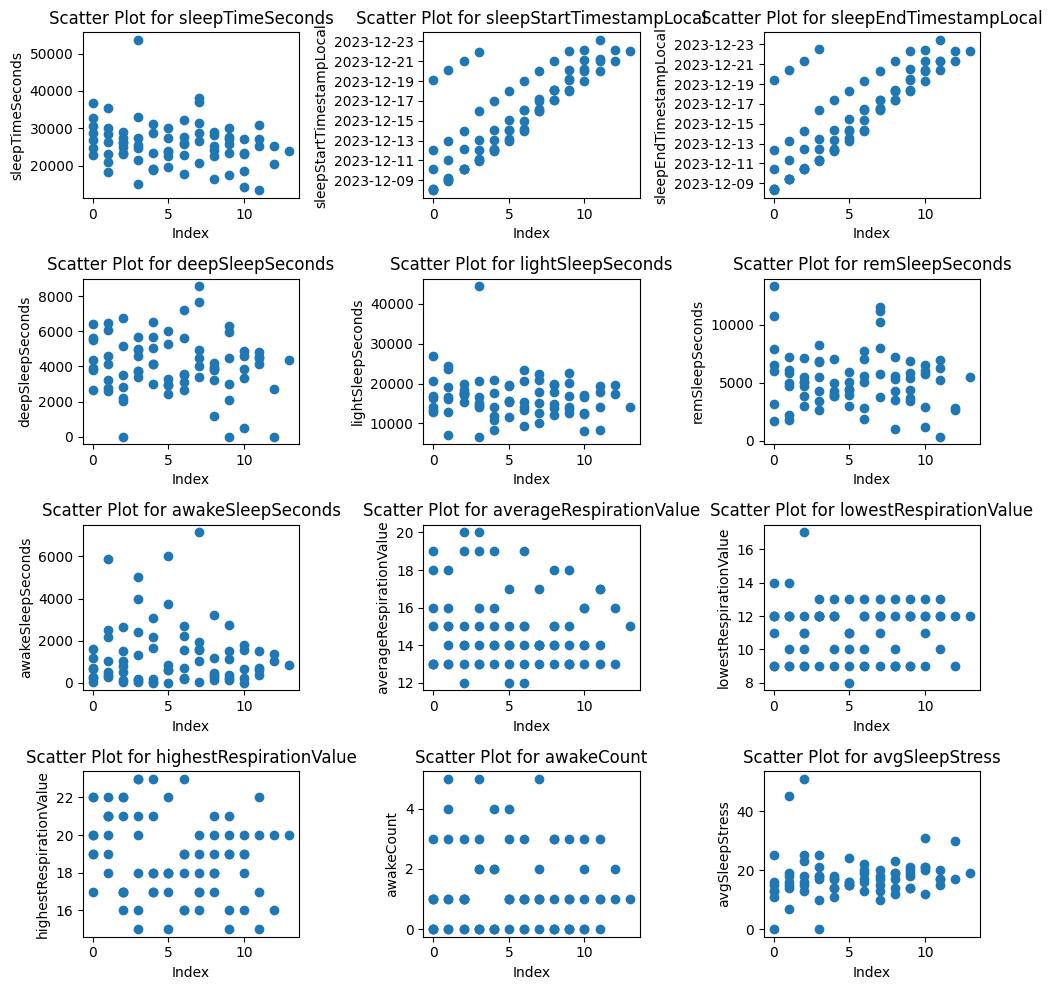

In [59]:
columns_to_plot = data.columns[3:15].tolist() # Replace with your actual column names
 
# Set the number of rows and columns for the subplot grid
num_rows = 4
num_columns = 3  # Since you have 10 plots, and you want 2 rows, you'll need 5 columns

# Create subplots with the appropriate grid size
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(10, 10))

# Flatten the axes array for easy iteration if it's 2D
axes = axes.flatten()

# Loop through the list of columns and create a scatter plot for each
for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    ax.scatter(data.index, data[column])
    ax.set_title(f'Scatter Plot for {column}')
    ax.set_xlabel('Index')
    ax.set_ylabel(column)

# Hide any unused subplots if you have them
for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout so that titles and labels do not overlap
plt.tight_layout()
plt.show()

## PCA

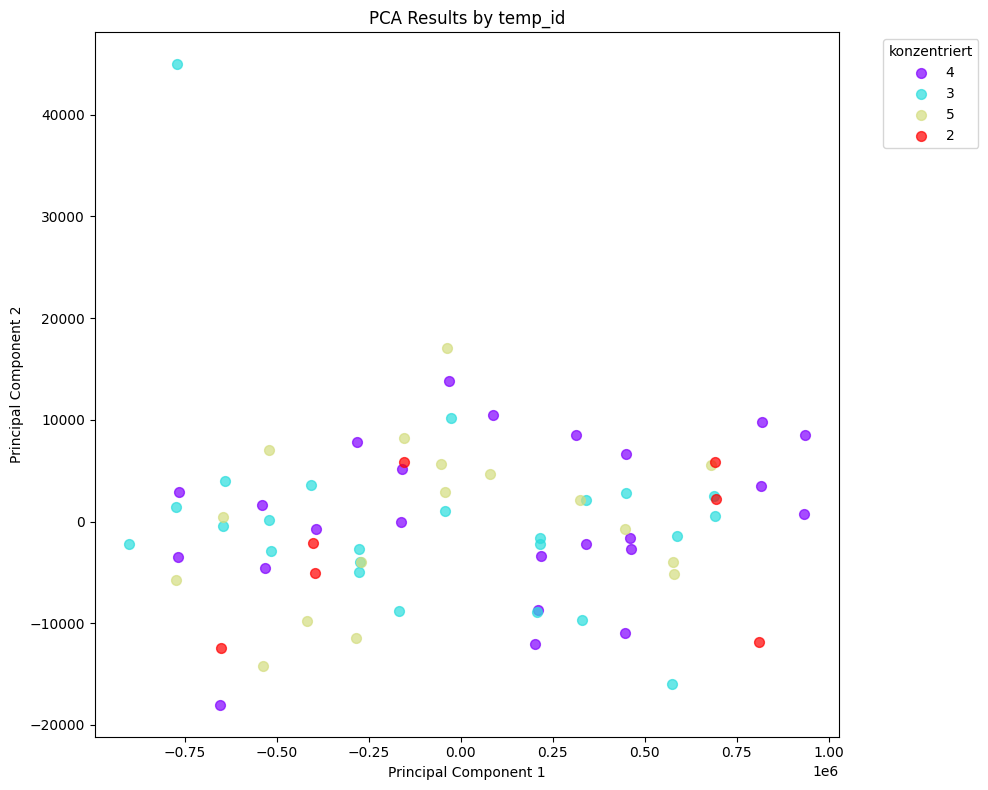

In [40]:
data_with_pca = pd.concat([copy_data_clean, df], axis='columns')

# Unique identifiers in 'temp_id'
unique_ids = copy_data_clean['konzentriert'].unique()

# Create a color map, assigning a unique color to each temp_id
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_ids)))

# Map each temp_id to a color
color_map = dict(zip(unique_ids, colors))

# Create a scatter plot
plt.figure(figsize=(10, 8))

for temp_id in unique_ids:
    # Select data for each temp_id
    subset = data_with_pca[data_with_pca['konzentriert'] == temp_id]
    
    # Plot data with the color corresponding to the current temp_id
    plt.scatter(subset['PC1'], subset['PC2'], s=50, alpha=0.7, 
                color=color_map[temp_id], label=temp_id)

# Title and labels
plt.title('PCA Results by temp_id')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Legend
plt.legend(title='konzentriert', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

### Result

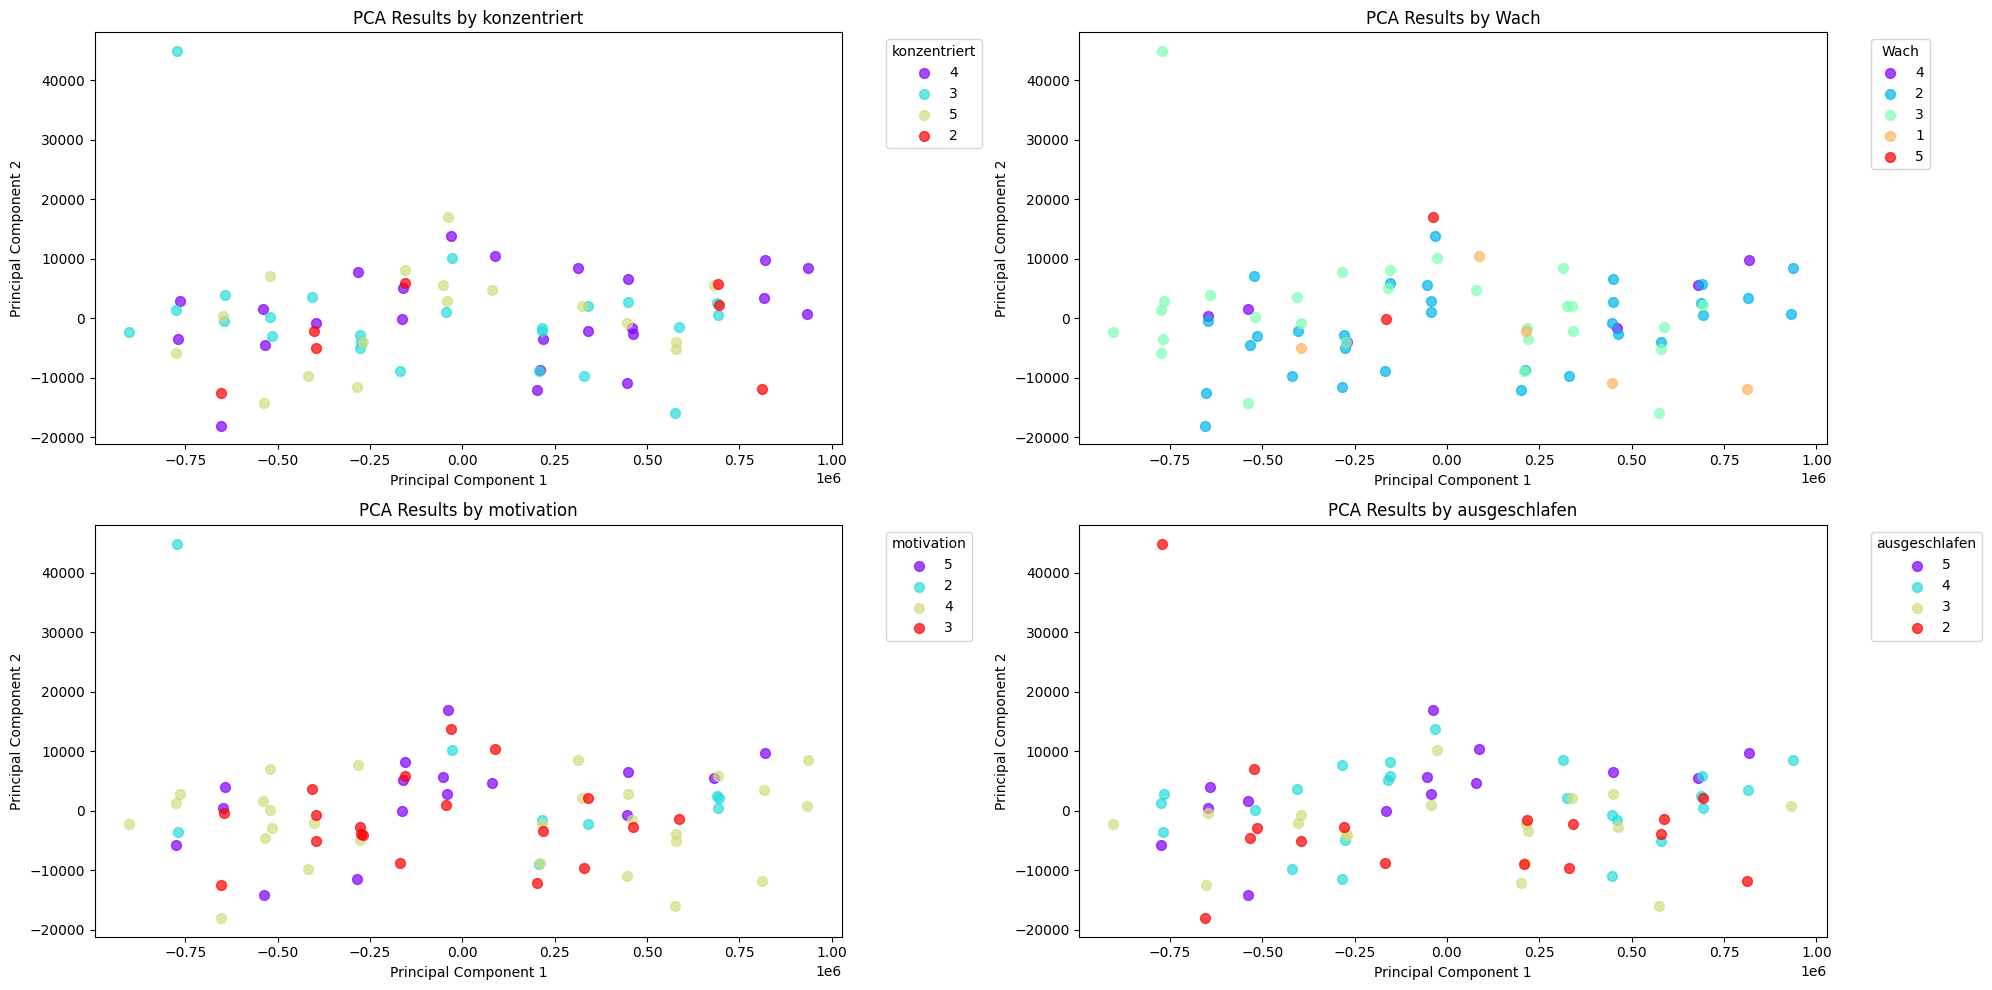

In [49]:
# Concatenate dataframes
data_with_pca = pd.concat([copy_data_clean, df], axis='columns')

# Define columns for coloring
color_columns = ['konzentriert', 'Wach', 'motivation', 'ausgeschlafen']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

for ax, color_column in zip(axes, color_columns):
    unique_values = data_with_pca[color_column].unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_values)))
    color_map = dict(zip(unique_values, colors))

    for value in unique_values:
        subset = data_with_pca[data_with_pca[color_column] == value]
        ax.scatter(subset['PC1'], subset['PC2'], s=50, alpha=0.7,
                   color=color_map[value], label=value)

    ax.set_title(f'PCA Results by {color_column}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

    # Legend
    ax.legend(title=color_column, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


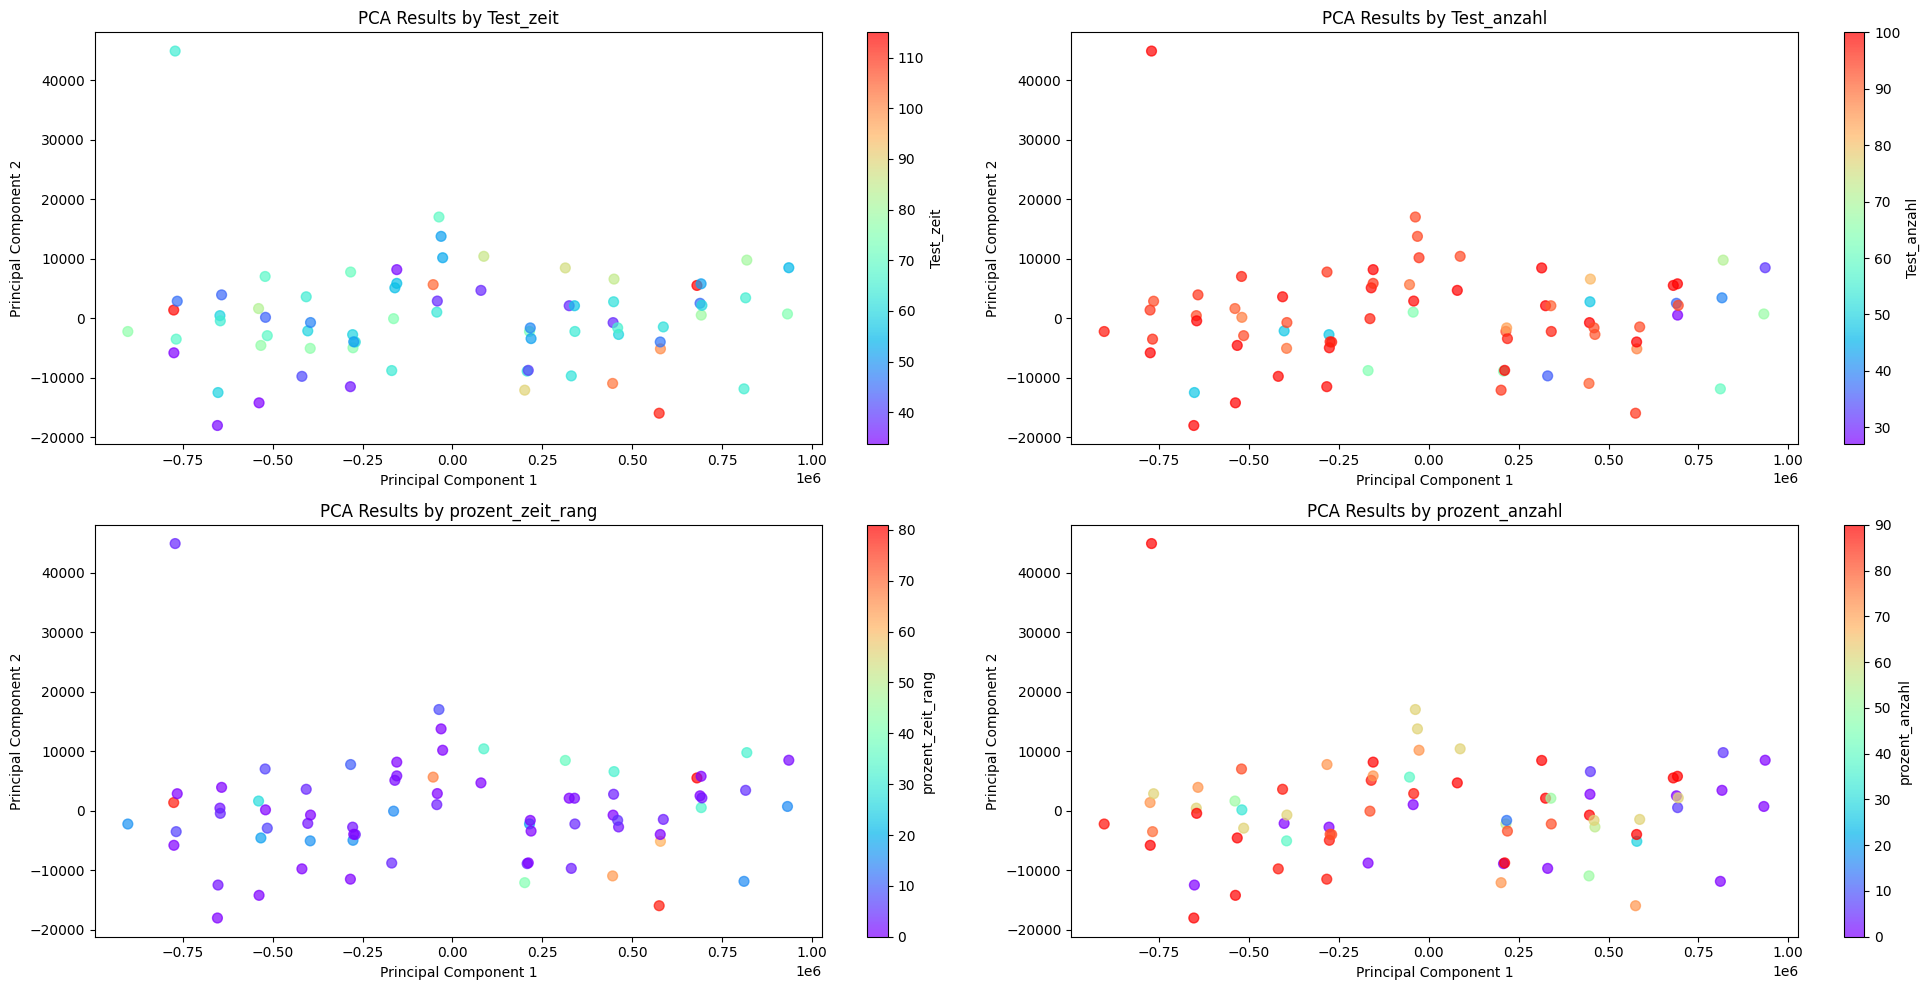

In [50]:
# Concatenate dataframes
data_with_pca = pd.concat([copy_data_clean, df], axis='columns')

# Define columns for coloring
color_columns = ['Test_zeit', 'Test_anzahl', 'prozent_zeit_rang', 'prozent_anzahl']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

for ax, continuous_column in zip(axes, continuous_columns):
    # Continuous variables: Add colorbar
    sc = ax.scatter(data_with_pca['PC1'], data_with_pca['PC2'], c=data_with_pca[continuous_column],
                    cmap='rainbow', s=50, alpha=0.7)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(continuous_column)

    ax.set_title(f'PCA Results by {continuous_column}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()


## t-sne

In [153]:
# tsne
from sklearn.manifold import TSNE

data_tsne = TSNE(n_components=2, learning_rate='auto', perplexity=60,
                random_state=42).fit_transform(data_clean)

data_tsne.shape
df_tsne = pd.DataFrame(data_tsne, columns=['tsne_1', 'tsne_2'])

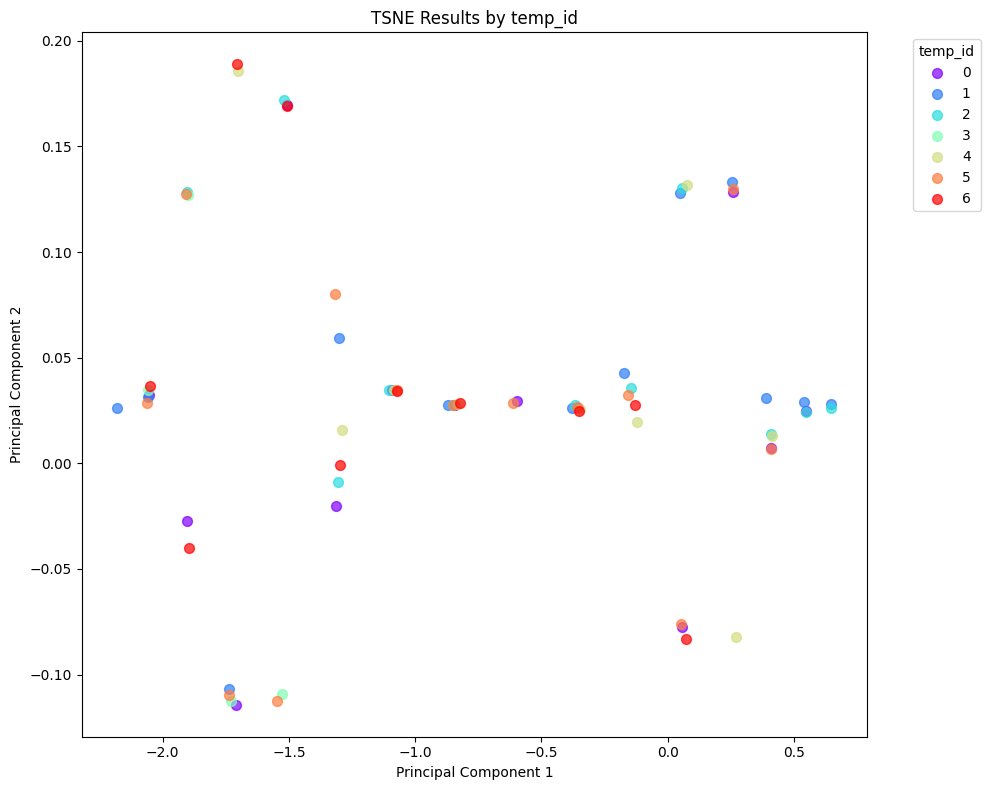

In [154]:
data_with_tsne = pd.concat([copy_data_clean, df_tsne], axis='columns')

# Unique identifiers in 'temp_id'
unique_ids = copy_data_clean['temp_id'].unique()

# Create a color map, assigning a unique color to each temp_id
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_ids)))

# Map each temp_id to a color
color_map = dict(zip(unique_ids, colors))

# Create a scatter plot
plt.figure(figsize=(10, 8))

for temp_id in unique_ids:
    # Select data for each temp_id
    subset = data_with_tsne[data_with_tsne['temp_id'] == temp_id]
    
    # Plot data with the color corresponding to the current temp_id
    plt.scatter(subset['tsne_1'], subset['tsne_2'], s=50, alpha=0.7, 
                color=color_map[temp_id], label=temp_id)

# Title and labels
plt.title('TSNE Results by temp_id')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Legend
plt.legend(title='temp_id', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

### Result (Cluster)

C:\Users\Asus\anaconda3\envs\dig_health\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



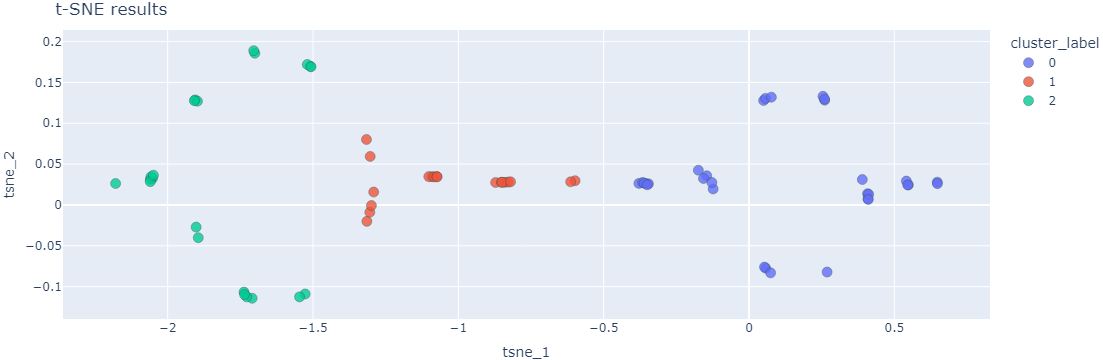

In [157]:
from sklearn.cluster import KMeans
import plotly.express as px

# Assuming data_tsne is already your DataFrame with the t-SNE results
# and 'tsne_1', 'tsne_2' are the column names for the t-SNE components

# Perform K-means clustering
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(data_tsne)
df_tsne['cluster'] = kmeans.labels_

# Convert cluster numbers into string labels for better readability in the plot
df_tsne['cluster_label'] = df_tsne['cluster'].astype(str)

data_with_tsne = pd.concat([copy_data_clean, df_tsne], axis='columns')

labels_column = ['temp_id', 'konzentriert', 'motivation', 'prozent_zeit_rang', 'awakeSleepSeconds']

# Create a new column based on the threshold
data_with_tsne['concentration_result'] = data_with_tsne['prozent_zeit_rang'].apply(lambda x: 1 if x < 20 else 0)

# Create a scatter plot using Plotly Express
fig = px.scatter(data_with_tsne, x='tsne_1', y='tsne_2',
                 color='cluster_label',  # Color by new concentration status
                 #symbol='concentration_result',  # Map 'konzentriert' values to different shapes
                 hover_data=labels_column,  # Include additional data in hover tooltips
                 title='t-SNE results')

# Customize the layout to move the legend to the left side
fig.update_layout(
                  #legend=dict(title_font=dict(size=12), font=dict(size=10), x=0, y=1, bgcolor='rgba(255,255,255,0.5)'),
                  margin=dict(l=0, r=0, t=30, b=0))

# Adjust marker settings for better visibility
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=0.5, color='DarkSlateGrey')))

# Hide the legend for 'cluster_label'
fig.update_traces(showlegend=False, selector=dict(name='cluster_label'))

# Show the plot
fig.show()

### Result (False Claim)

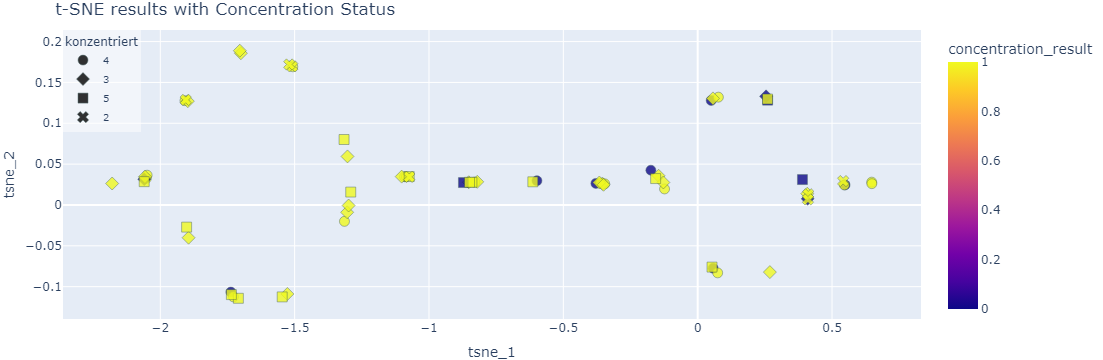

In [156]:
# Convert cluster numbers into string labels for better readability in the plot
df_tsne['cluster_label'] = df_tsne['cluster'].astype(str)

data_with_tsne = pd.concat([copy_data_clean, df_tsne], axis='columns')

labels_column = ['temp_id', 'konzentriert', 'motivation', 'prozent_zeit_rang']

# Create a new column based on the threshold
data_with_tsne['concentration_result'] = data_with_tsne['prozent_zeit_rang'].apply(lambda x: 1 if x < 20 else 0)

# Create a scatter plot using Plotly Express
fig = px.scatter(data_with_tsne, x='tsne_1', y='tsne_2',
                 color='concentration_result',  # Color by new concentration status
                 symbol='konzentriert',  # Map 'konzentriert' values to different shapes
                 hover_data=labels_column,  # Include additional data in hover tooltips
                 title='t-SNE results with Concentration Status')

# Customize the layout to move the legend to the left side
fig.update_layout(
                  legend=dict(title_font=dict(size=12), font=dict(size=10), x=0, y=1, bgcolor='rgba(255,255,255,0.5)'),
                  margin=dict(l=0, r=0, t=30, b=0))

# Adjust marker settings for better visibility
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=0.5, color='DarkSlateGrey')))

# Show the plot
fig.show()

## UMAP

C:\Users\Asus\anaconda3\envs\dig_health\lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

C:\Users\Asus\anaconda3\envs\dig_health\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

C:\Users\Asus\anaconda3\envs\dig_health\lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

C:\Users\Asus\anaconda3\envs\dig_health\lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



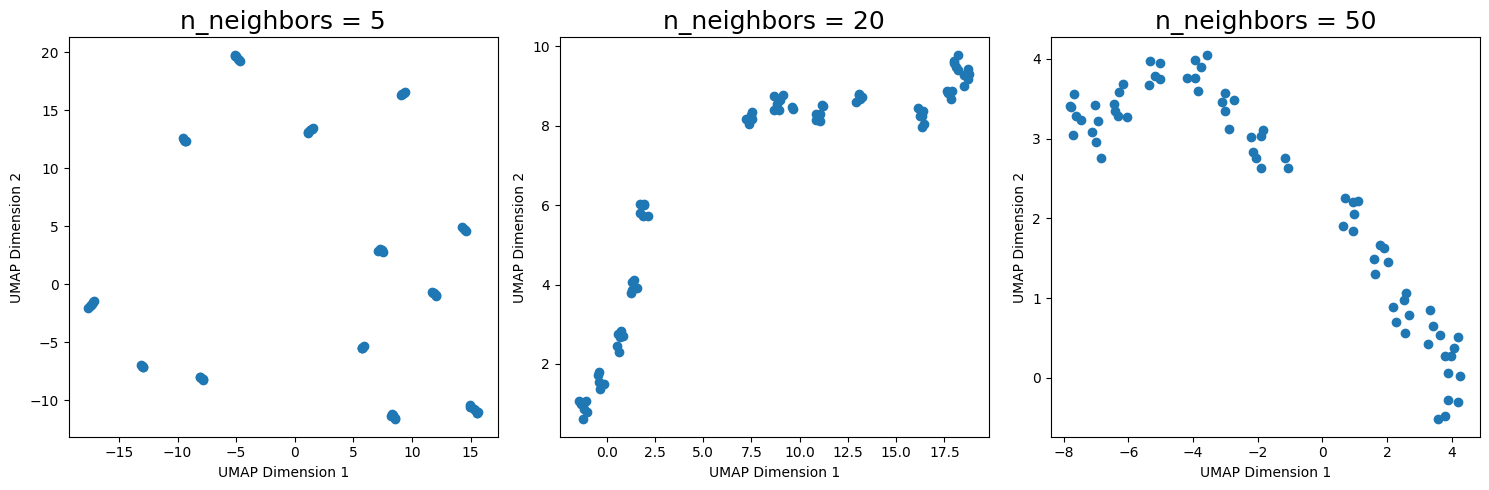

In [124]:
# Revised draw_umap function
def draw_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=30
    ).fit(data)

    #colors = plt.cm.Spectral(np.linspace(0, 1, len(data)))

    if n_components == 1:
        plt.scatter(fit.embedding_[:, 0], range(len(fit.embedding_)),)# c=colors)
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('Index')
    elif n_components == 2:
        plt.scatter(fit.embedding_[:, 0], fit.embedding_[:, 1],)# c=colors)
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
    elif n_components == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(fit.embedding_[:, 0], fit.embedding_[:, 1], fit.embedding_[:, 2], s=100)
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        ax.set_zlabel('UMAP Dimension 3')

    plt.title(title, fontsize=18)

# Creating subplots outside of draw_umap
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

n_neighbors_values = [5, 20, 50]


# Iterate over axes and n_neighbors_values
for ax, n in zip(axes.flatten(), n_neighbors_values):
    plt.sca(ax)  # Set the current Axes, allowing draw_umap to plot on it
    draw_umap(data_clean, n_neighbors=n, title=f'n_neighbors = {n}')

plt.tight_layout()
plt.show()

C:\Users\Asus\anaconda3\envs\dig_health\lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

C:\Users\Asus\anaconda3\envs\dig_health\lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

C:\Users\Asus\anaconda3\envs\dig_health\lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



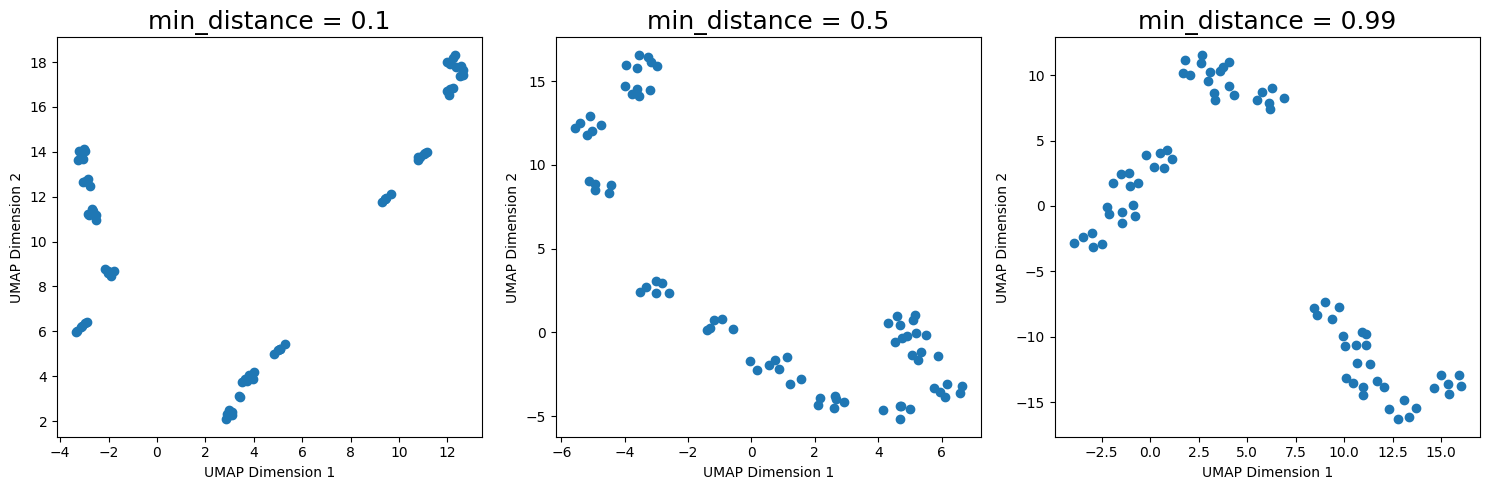

In [126]:
# Revised draw_umap function
def draw_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=30
    ).fit(data)

    #colors = plt.cm.Spectral(np.linspace(0, 1, len(data)))

    if n_components == 1:
        plt.scatter(fit.embedding_[:, 0], range(len(fit.embedding_)), )
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('Index')
    elif n_components == 2:
        plt.scatter(fit.embedding_[:, 0], fit.embedding_[:, 1], )
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
    elif n_components == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(fit.embedding_[:, 0], fit.embedding_[:, 1], fit.embedding_[:, 2], s=100)
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        ax.set_zlabel('UMAP Dimension 3')

    plt.title(title, fontsize=18)

# Creating subplots outside of draw_umap
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

n_distance_values = [0.1, 0.5, 0.99]


# Iterate over axes and n_neighbors_values
for ax, n in zip(axes.flatten(), n_distance_values):
    plt.sca(ax)  # Set the current Axes, allowing draw_umap to plot on it
    draw_umap(data_clean, min_dist=n, title=f'min_distance = {n}')

plt.tight_layout()
plt.show()

C:\Users\Asus\anaconda3\envs\dig_health\lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



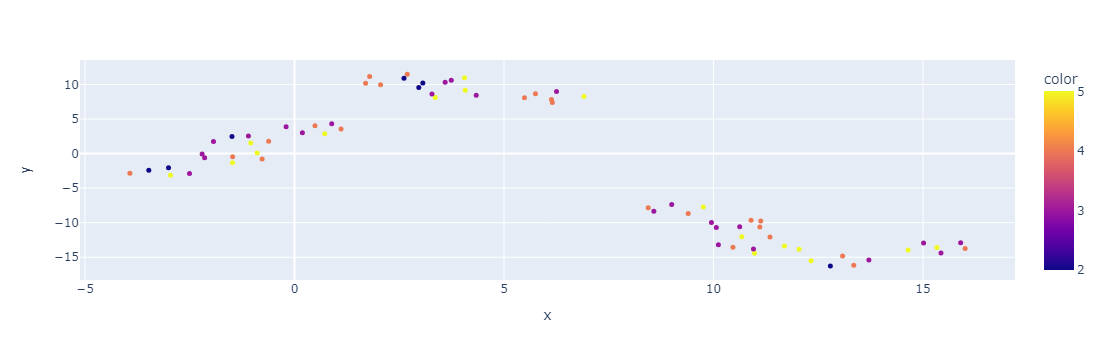

In [138]:
import umap
import plotly.express as px

reducer = umap.UMAP(random_state=30, n_neighbors=15, min_dist=0.99)
embedding = reducer.fit_transform(data_clean)

df_umap = pd.DataFrame(embedding)
data_with_umap = pd.concat([copy_data_clean, df_umap], axis='columns')

labels_column = ['temp_id', 'konzentriert', 'motivation', 'prozent_zeit_rang']

fig = px.scatter(x=embedding[:, 0], y=embedding[:, 1], color=data_with_umap['konzentriert'])
fig.update_traces(marker=dict(size=5))
fig.show()

In [74]:
for col in data_with_umap.columns[:-2]:
    if 'ideal' in col:
        print(True)

## Correlation matrix

In [35]:
cols_ = []

for col in data_clean.columns.tolist():
    if 'embedding' in col:
        continue
    cols_.append(col)

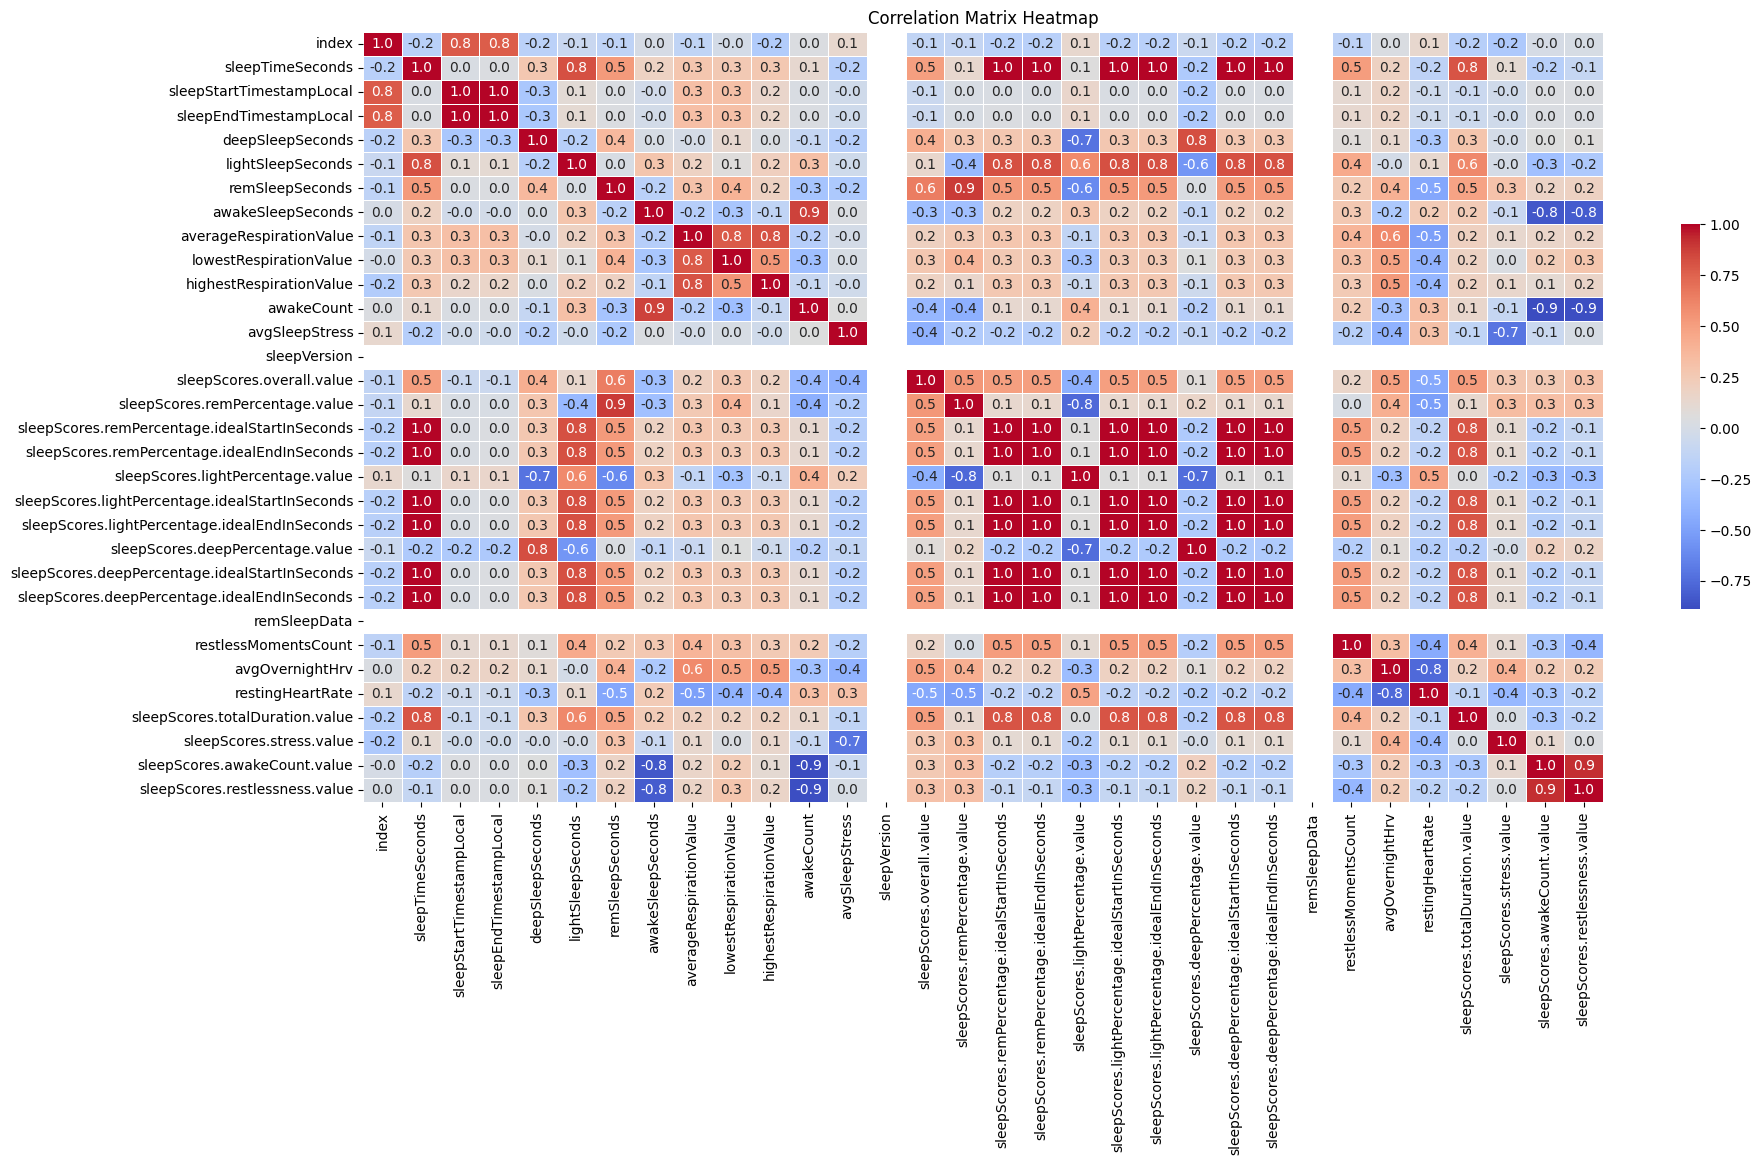

In [36]:
import seaborn as sns

# Step 1: Calculate the correlation matrix
corr_matrix = data_clean[cols_].corr()

# Step 2: Plot the heatmap
plt.figure(figsize=(20, 10))  # Set the figure size for better readability
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f", 
            linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix Heatmap')
plt.show()

In [45]:
data_filtered

,sleepTimeSeconds,sleepStartTimestampLocal,sleepEndTimestampLocal,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,averageRespirationValue,avgSleepStress,sleepScores.overall.value,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
0,29940,1702082460,1702114920,3240,24480,2220,2520,15.0,45.0,46,...,0.0,2.403386,2.422224,1.581123,0.029759,0.000000,0.0,0.000000,0.350698,0.0
1,25080,1702175520,1702201140,2040,17580,5460,540,14.0,25.0,73,...,0.0,1.174797,2.238895,2.448936,0.778737,0.000000,0.0,0.000000,0.000000,0.0
2,21420,1702257840,1702279320,3720,15000,2700,60,15.0,25.0,69,...,0.0,0.544954,2.681309,1.326715,0.034641,0.362635,0.0,0.000000,0.000000,0.0
3,31080,1702344300,1702375440,6540,17520,7020,60,15.0,17.0,91,...,0.0,0.630449,1.376675,2.312008,1.645187,0.000000,0.0,0.000000,0.000000,0.0
4,23880,1702513740,1702538460,5280,15600,3000,840,14.0,24.0,73,...,0.0,1.339422,2.192270,1.335280,0.000000,0.549342,0.0,0.455504,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,22620,1702860240,1702883460,2940,15720,3960,600,17.0,15.0,74,...,0.0,0.230617,1.315638,2.043450,0.000000,0.828357,0.0,0.000000,0.000000,0.0
68,25800,1702943820,1702969800,2640,15420,7740,180,19.0,16.0,82,...,0.0,0.455000,1.363487,3.056053,0.450782,0.000000,0.0,0.000000,0.000000,0.0
69,26520,1703031600,1703059140,3420,15120,7980,1020,17.0,13.0,85,...,0.0,0.799219,1.109627,2.228616,0.000000,0.000000,0.0,0.020009,0.000000,0.0
70,28320,1703117400,1703146020,1200,19860,7260,300,18.0,12.0,80,...,0.0,1.017511,0.688720,2.953455,0.074318,0.000000,0.0,0.000000,0.000000,0.0
